## update from V5 to V8

### After evaluate v6 and v7, normalize the model for Random Forest is not necessory
### this version is developed from V5


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score  # Importing the mean_squared_error function
from sklearn.impute import SimpleImputer
import xgboost as xgb
import shap

# Load data
data = pd.read_csv('Merged Data.csv', parse_dates=['Date'])

C:\Users\gaoqian\AppData\Local\Temp\ipykernel_1124\1695878047.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


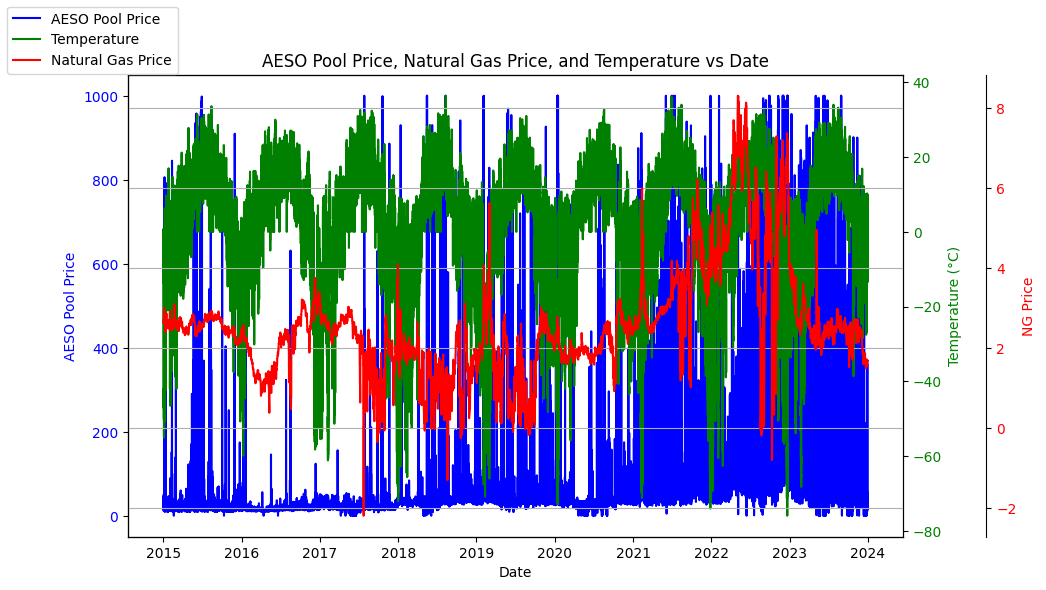

In [2]:


# Create a single plot with separate y-axes for temperature and NG price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pool Price
ax1.plot(data['Date'], data['AESO Pool Price CAD/MWh'], label='AESO Pool Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('AESO Pool Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Temp Calgary deg C'], label='Temperature', color='green')
ax2.set_ylabel('Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis for the NG price
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(data['Date'], data['AECO 2A CAD/GJ'], label='Natural Gas Price', color='red')
ax3.set_ylabel('NG Price', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a legend with custom handles
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper left')

plt.title("AESO Pool Price, Natural Gas Price, and Temperature vs Date")
plt.grid(True)
plt.show()

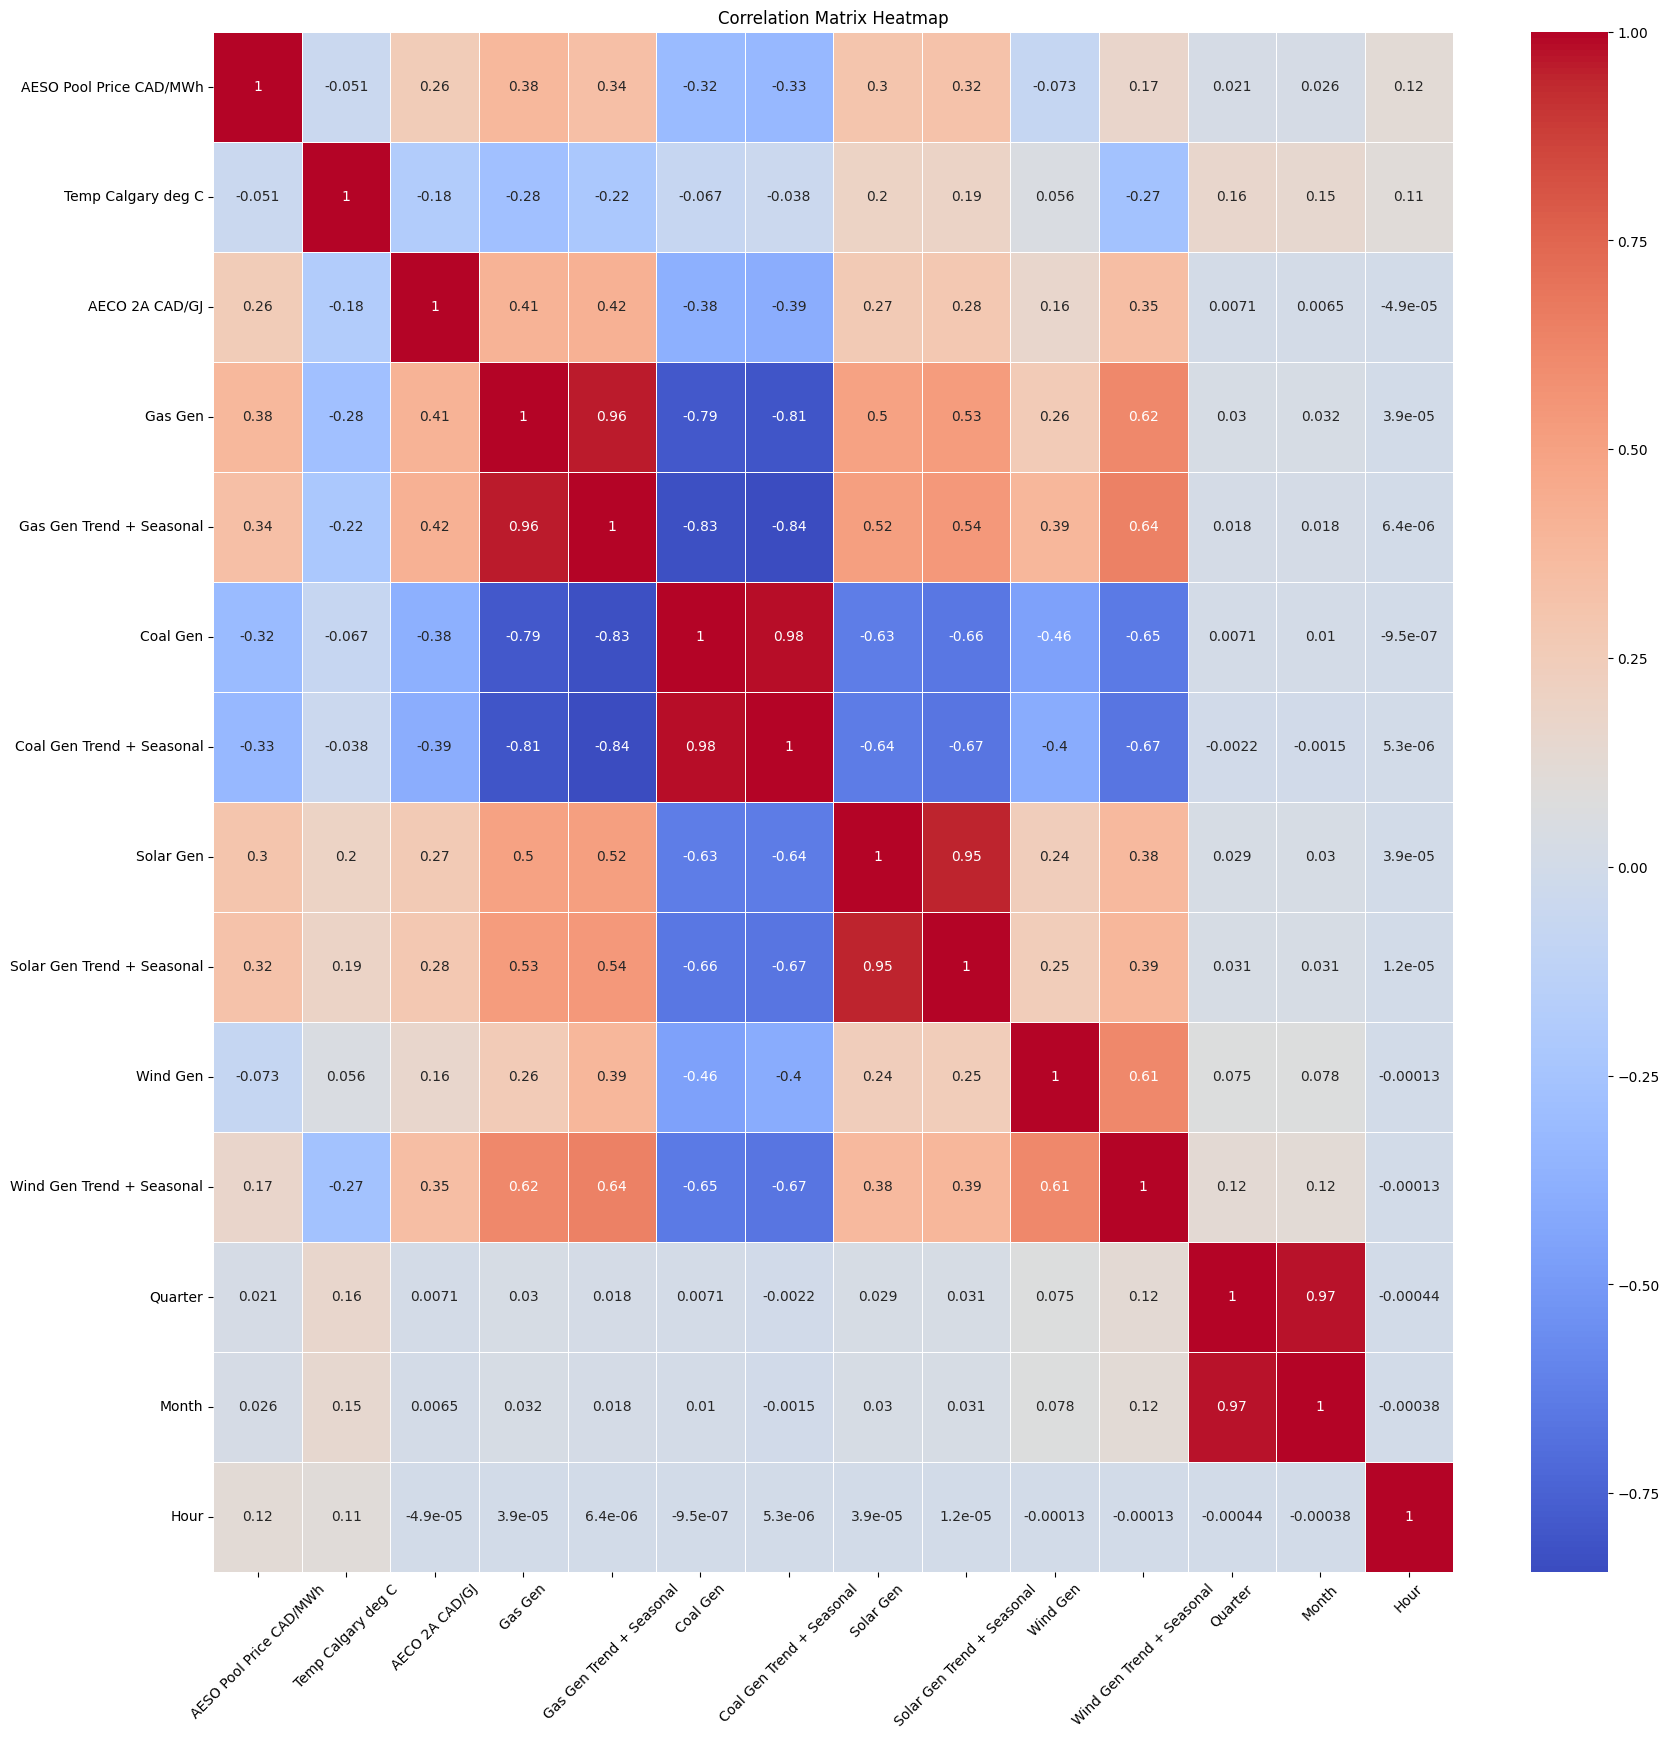

In [3]:
data_numeric = data.drop(['Date','Date Daily'], axis=1)

correlation_matrix = data_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot (optional)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [4]:
data.head()

,Date,AESO Pool Price CAD/MWh,Date Daily,Temp Calgary deg C,AECO 2A CAD/GJ,Gas Gen,Gas Gen Trend + Seasonal,Coal Gen,Coal Gen Trend + Seasonal,Solar Gen,Solar Gen Trend + Seasonal,Wind Gen,Wind Gen Trend + Seasonal,Quarter,Month,Hour
0,2015-01-01 00:00:00,37.45,2015-01-01,-13.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,0
1,2015-01-01 01:00:00,34.62,2015-01-01,-2.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,1
2,2015-01-01 02:00:00,22.80,2015-01-01,-6.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,2
3,2015-01-01 03:00:00,21.05,2015-01-01,-7.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,3
4,2015-01-01 04:00:00,20.79,2015-01-01,-6.7,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,4


## Random Forest Regression Model - Random split data

Temp Calgary deg C: 0.3891
AECO 2A CAD/GJ: 0.0767
Gas Gen: 0.8736
Gas Gen Trend + Seasonal: 0.3954
Coal Gen: 0.0516
Coal Gen Trend + Seasonal: 0.0852
Solar Gen: 0.0463
Solar Gen Trend + Seasonal: 0.2989
Wind Gen: 0.3349
Wind Gen Trend + Seasonal: 0.0904
Quarter: 0.0019
Month: 0.0260
Hour: 0.3739
Random Forest Mean Squared Error: 3932.7986343309803
Random Forest R-squared: 0.7637101623356098


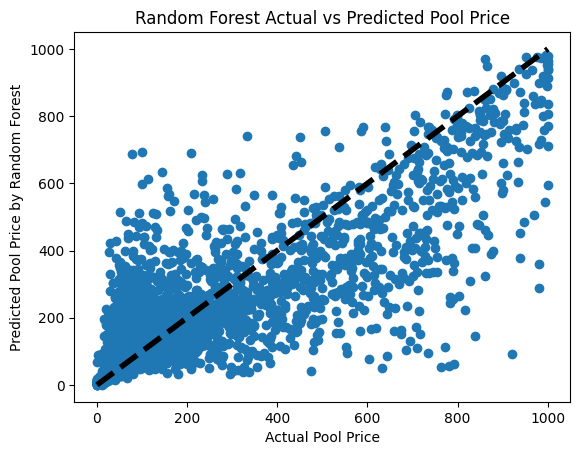

In [5]:
# Sort the data by date
df = data.sort_values(by='Date')

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']])

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

### use median instead of mean to handle missing values

Temp Calgary deg C: 0.3891
AECO 2A CAD/GJ: 0.0767
Gas Gen: 0.8736
Gas Gen Trend + Seasonal: 0.3954
Coal Gen: 0.0516
Coal Gen Trend + Seasonal: 0.0852
Solar Gen: 0.0463
Solar Gen Trend + Seasonal: 0.2989
Wind Gen: 0.3349
Wind Gen Trend + Seasonal: 0.0904
Quarter: 0.0019
Month: 0.0260
Hour: 0.3739
Random Forest Mean Squared Error: 3932.7986343309803
Random Forest R-squared: 0.7637101623356098


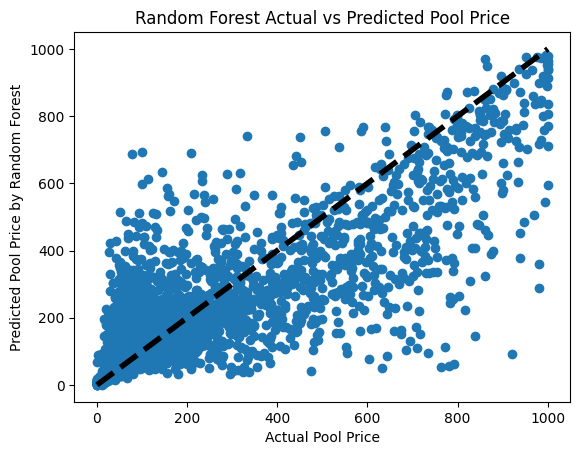

In [6]:
# Sort the data by date
df = data.sort_values(by='Date')

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']])

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

### conclusion: 
### data is pretty clean, no difference between using median and mean approach

In [10]:
# Define Random Search to find the best parameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution (e.g., uniform or discrete)
param_dist = {'n_estimators': randint(50, 2000)}

# Create the random search object
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0),
                                   param_distributions=param_dist,
                                   n_iter=10,  # Number of random samples
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1)

# Fit the random search to your data
random_search.fit(X_train, y_train)

best_n_estimators_random = random_search.best_params_['n_estimators']
print(f'Best n_estimators (random search): {best_n_estimators_random}')

c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gaoqia

Best n_estimators (random search): 1317


## adjust number of estimators to best 1317

### 1317

Temp Calgary deg C: 0.3906
AECO 2A CAD/GJ: 0.0766
Gas Gen: 0.9974
Gas Gen Trend + Seasonal: 0.4286
Coal Gen: 0.0560
Coal Gen Trend + Seasonal: 0.0885
Solar Gen: 0.0422
Solar Gen Trend + Seasonal: 0.3113
Wind Gen: 0.3248
Wind Gen Trend + Seasonal: 0.0887
Quarter: 0.0020
Month: 0.0230
Hour: 0.3770
Random Forest Mean Squared Error: 3850.491759020306
Random Forest R-squared: 0.7686553120913209


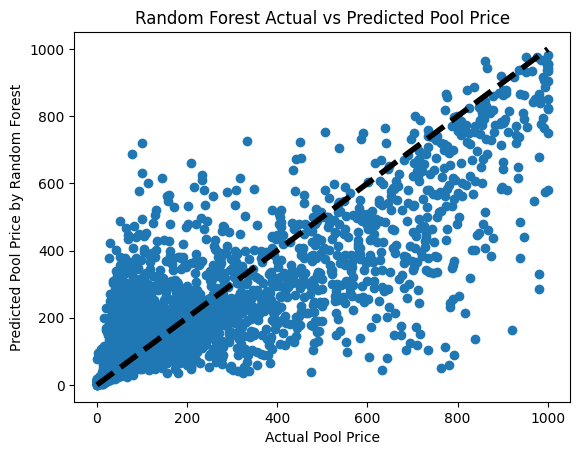

In [11]:
# Sort the data by date
df = data.sort_values(by='Date')

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']])

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1317, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

Random Forest Mean Squared Error: 3850.4918
Random Forest R-squared: 0.7687


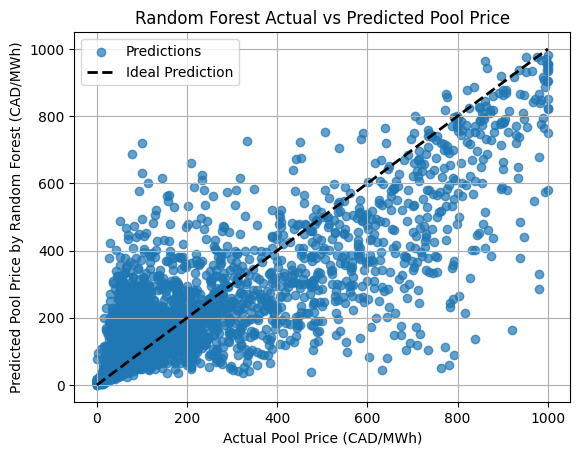

In [12]:
print(f'Random Forest Mean Squared Error: {mse_rf:.4f}')
print(f'Random Forest R-squared: {r2_rf:.4f}')

# Plotting the results
plt.scatter(y_test, y_pred_rf, label='Predictions', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Pool Price (CAD/MWh)')
plt.ylabel('Predicted Pool Price by Random Forest (CAD/MWh)')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Regression model with X_test.index 

Mean Squared Error: 3904.65
Root Mean Squared Error: 62.49
R-squared: 0.76


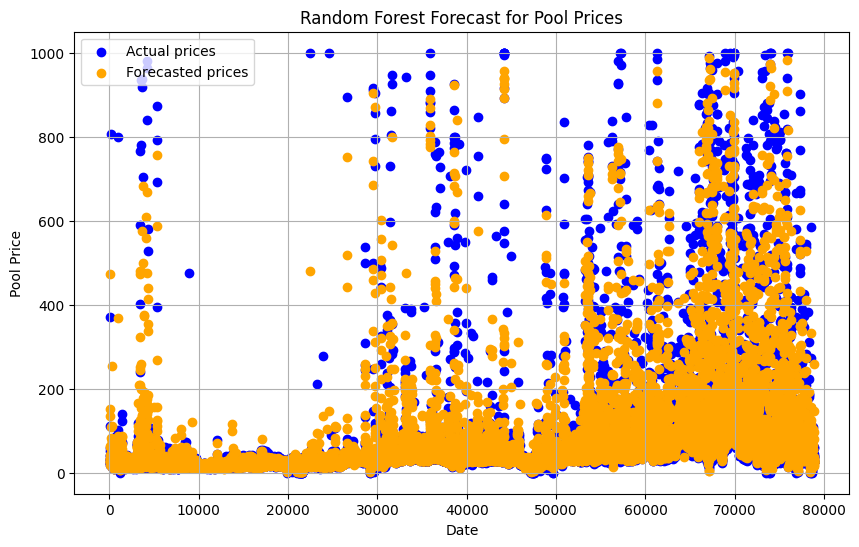

In [9]:
# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict future prices
y_pred = model.predict(X_test)

# Evaluate the model (MSE and RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# R-squared (Coefficient of Determination)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2:.2f}")

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, label='Actual prices', color='blue')
plt.scatter(X_test.index, y_pred, label='Forecasted prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Pool Price')
plt.title('Random Forest Forecast for Pool Prices')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost model with SHAP, random_state=42

100%|===================| 15762/15778 [00:27<00:00]        

Mean Squared Error: 3904.65
Root Mean Squared Error: 62.49
R-squared: 0.70


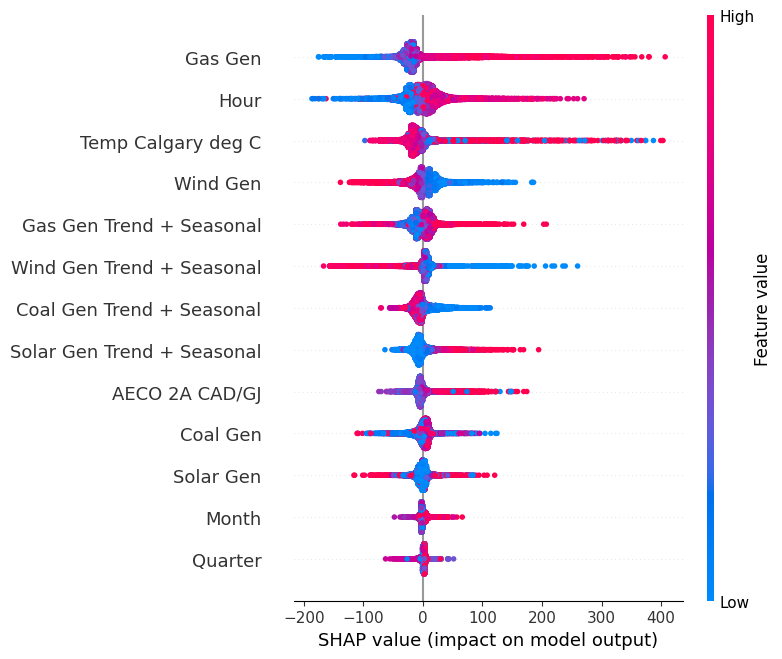

In [ ]:


# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Evaluate the model (MSE and RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# R-squared (Coefficient of Determination)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2:.2f}")

# Visualize feature importance (e.g., summary plot)
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

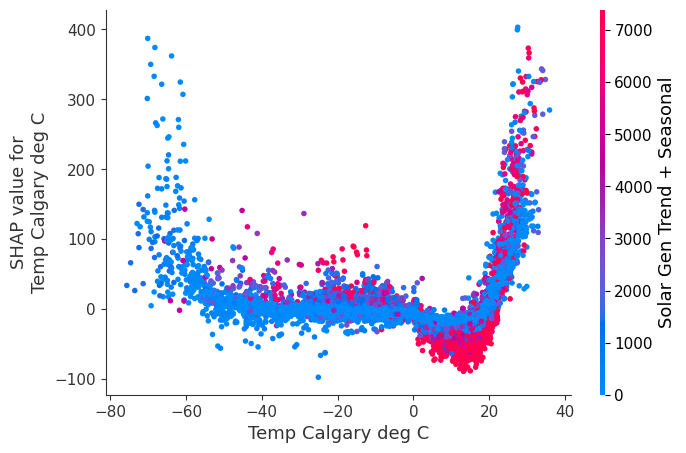

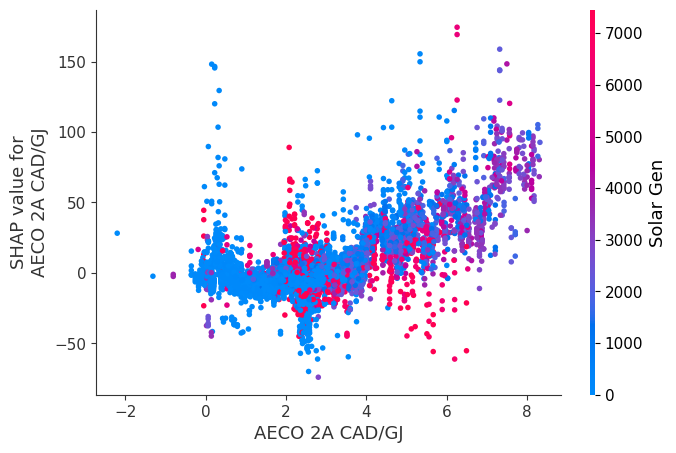

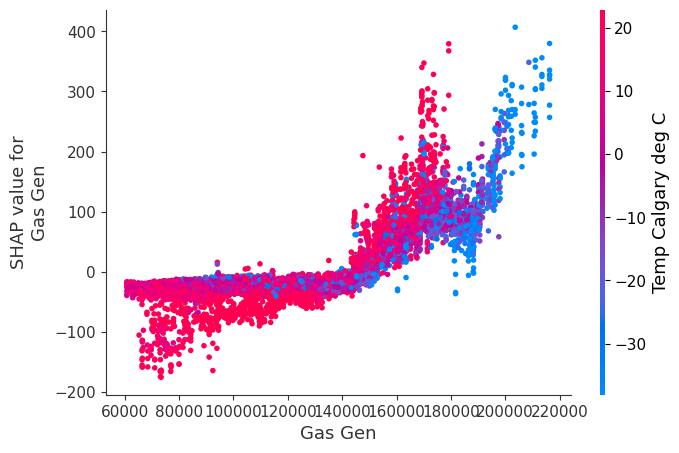

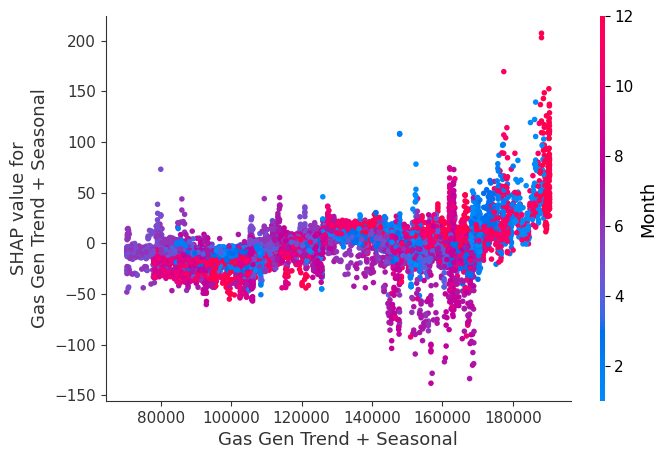

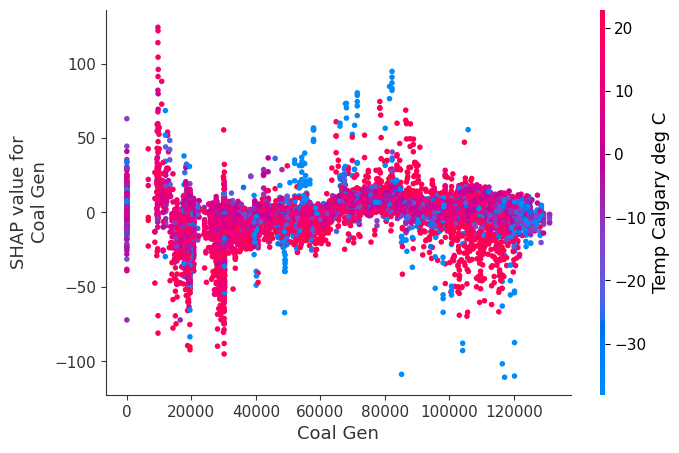

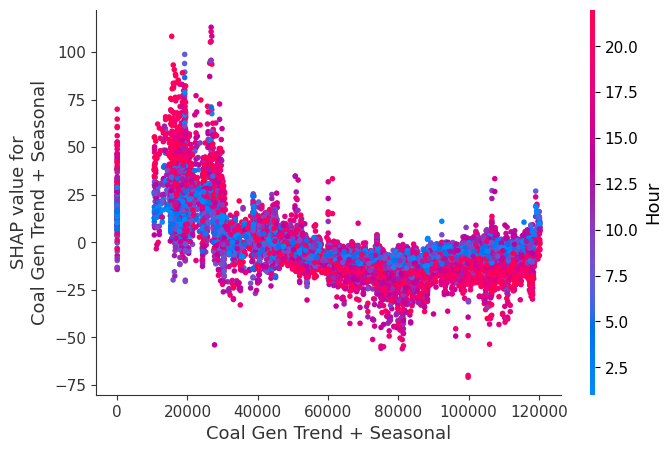

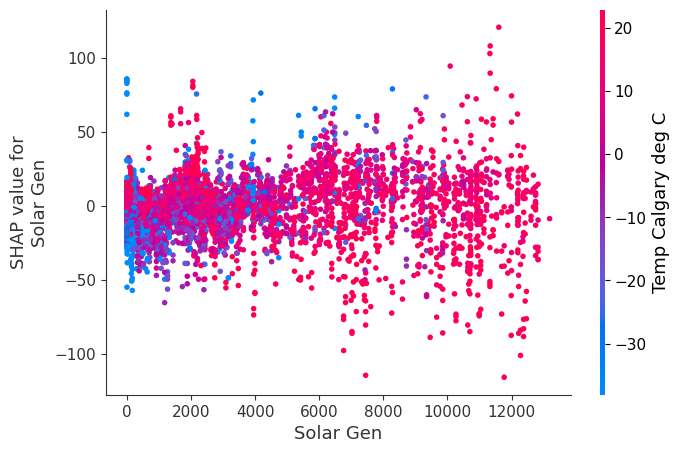

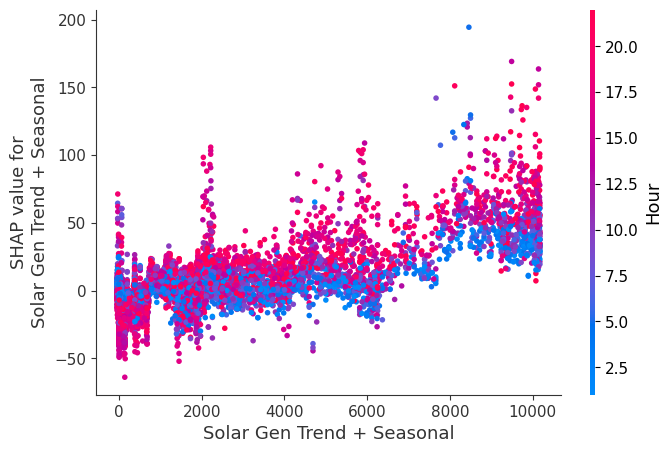

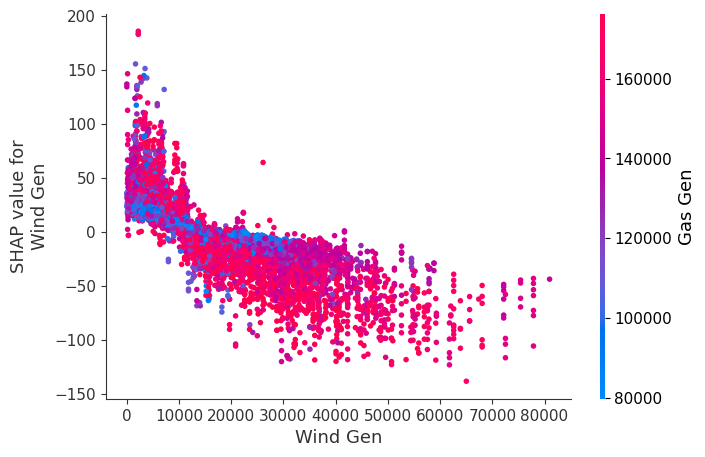

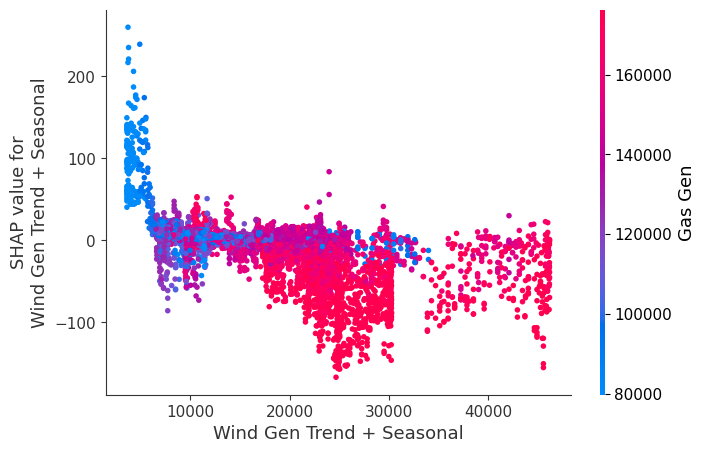

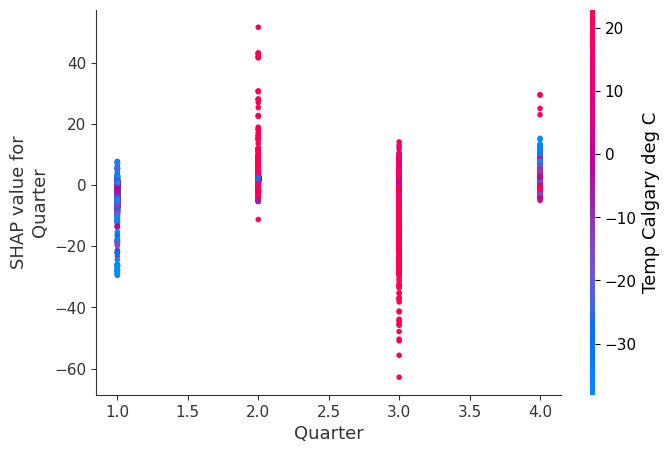

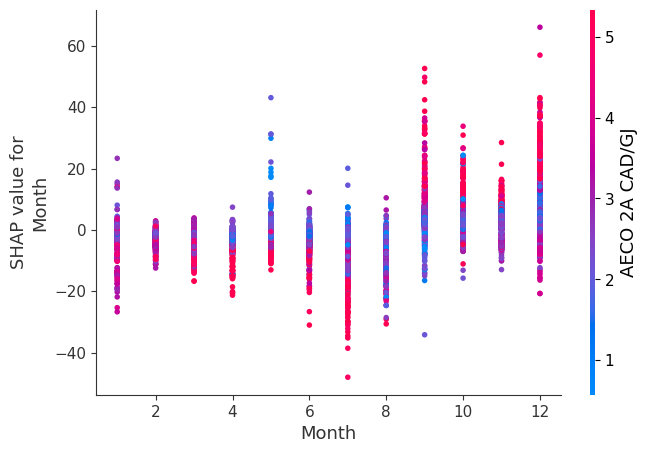

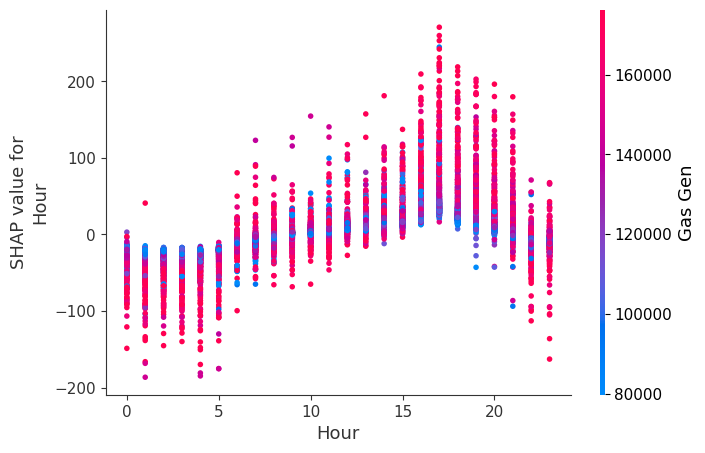

<Figure size 640x480 with 0 Axes>

In [ ]:
num_features = len(feature_names)

# Loop through each feature
for i in range(num_features):
    shap.dependence_plot(i, shap_values, X_test, feature_names=feature_names)


plt.tight_layout()
plt.show()

## XGBoost model with SHAP, Random_state=0

Mean Squared Error: 28539.57
Root Mean Squared Error: 168.94
R-squared: 0.69


 97%|=================== | 15304/15778 [00:28<00:00]       

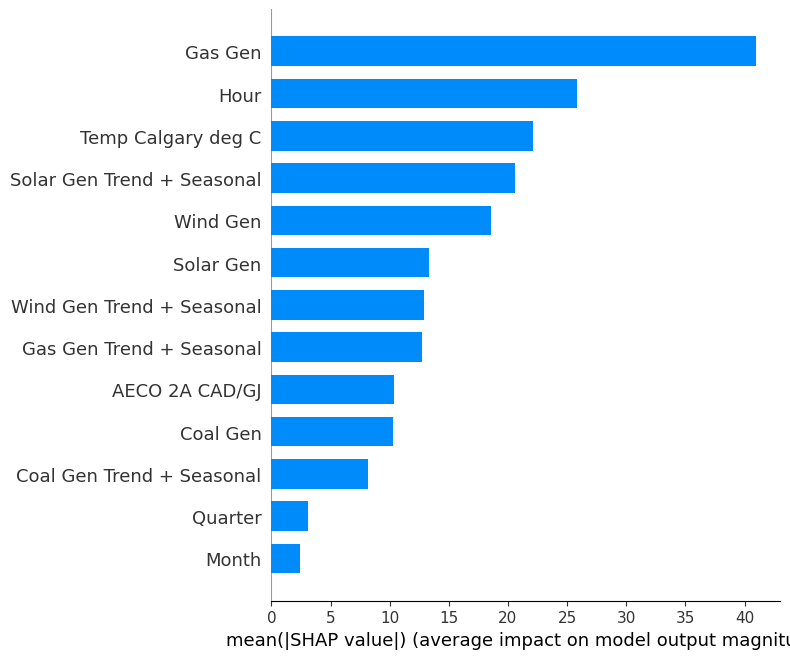

In [ ]:
# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Gas Gen','Gas Gen Trend + Seasonal','Coal Gen','Coal Gen Trend + Seasonal','Solar Gen','Solar Gen Trend + Seasonal','Wind Gen','Wind Gen Trend + Seasonal','Quarter','Month','Hour']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Evaluate the model (MSE and RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# R-squared (Coefficient of Determination)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2:.2f}")

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize feature importance (e.g., summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
